## portfolio allocation and risk assesment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from tqdm import tqdm

In [2]:
# Download and get Daily Returns
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [7]:
stocks = pd.concat([aapl,cisco,ibm,amzn],axis = 1)
stocks.columns = ['aapl','cisco','ibm','amzn']
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,53.063218,15.752778,160.830881,179.03
2012-01-04,53.348386,16.057180,160.174781,177.51
2012-01-05,53.940658,15.997991,159.415086,177.61
2012-01-06,54.504543,15.938801,157.584912,182.61
2012-01-09,54.418089,16.040268,156.764786,178.56


In [8]:
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [9]:
stocks.pct_change().corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [10]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


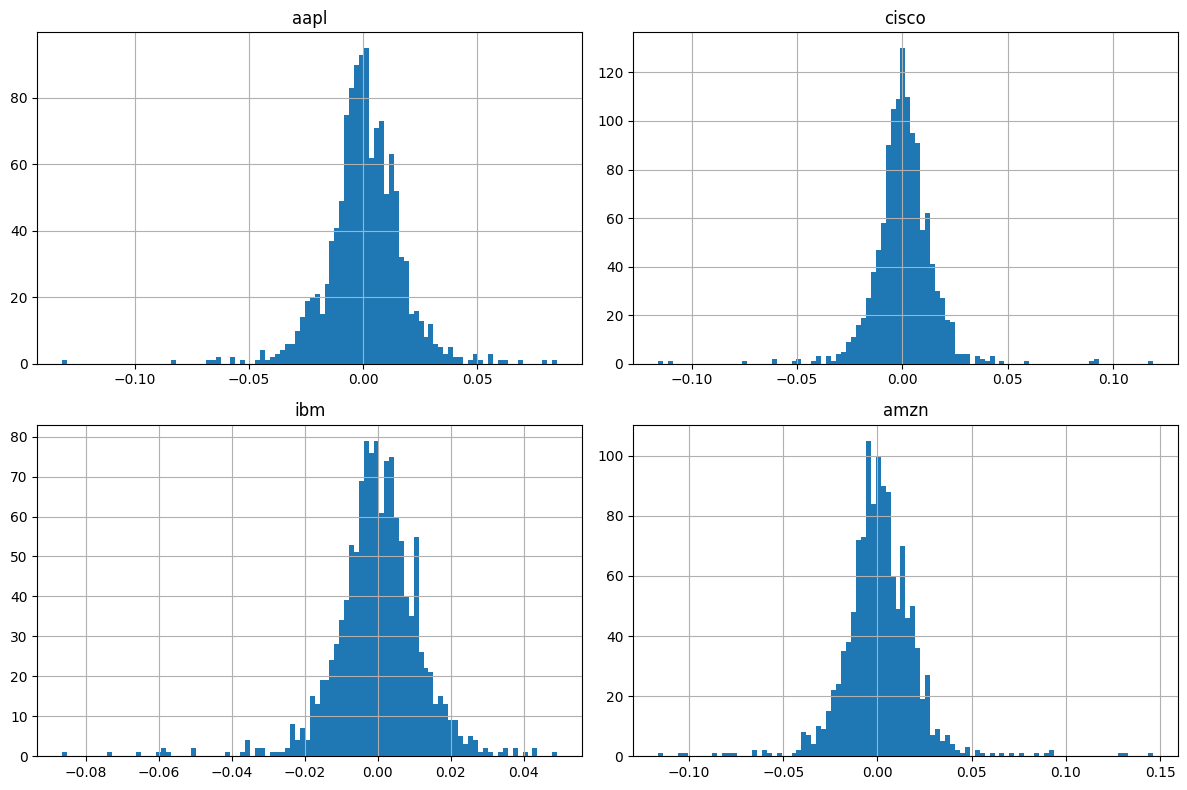

In [11]:
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

In [12]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000011
amzn     0.001139
dtype: float64

In [15]:
log_ret.cov()*252

,aapl,cisco,ibm,amzn
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amzn,0.018986,0.019956,0.014939,0.094470


In [22]:
np.random.seed(101)
print(stocks.columns)

weights = np.array(np.random.random(4))
print("Random weights")
print(weights)

print("Rebalance")
weights = weights/sum(weights)
print(weights)

print("Expected protfolio returns")
exp_ret = np.sum(log_ret.mean()*weights * 252)
print(exp_ret)

print("Expected volatility")
exp_volt  = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
print(exp_volt)

print("Sharpe Ratio")
SR = exp_ret/exp_volt # the greater the better
print(SR) 

Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')
Random weights
[0.51639863 0.57066759 0.02847423 0.17152166]
Rebalance
[0.40122278 0.44338777 0.02212343 0.13326603]
Expected protfolio returns
0.15599272049632026
Expected volatility
0.18502649565909488
Sharpe Ratio
0.8430831483926045


In [24]:
num_ports = 25000

all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

# Wrap the loop with tqdm
for ind in tqdm(range(num_ports), desc="Simulating Portfolios"):
    weights = np.array(np.random.random(4))
    weights = weights / sum(weights)

    all_weights[ind, :] = weights

    ret_arr[ind] = np.sum(log_ret.mean() * weights * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]


Simulating Portfolios: 100%|████████████| 25000/25000 [00:21<00:00, 1185.37it/s]


In [25]:
sharpe_arr.max()

np.float64(1.0292100564846767)

In [26]:
sharpe_arr.argmax()

np.int64(851)

In [27]:
all_weights[851,:]

array([0.26455872, 0.19092709, 0.00405137, 0.54046281])

In [28]:
max_sr_ret = ret_arr[851]
max_sr_vol = vol_arr[851]

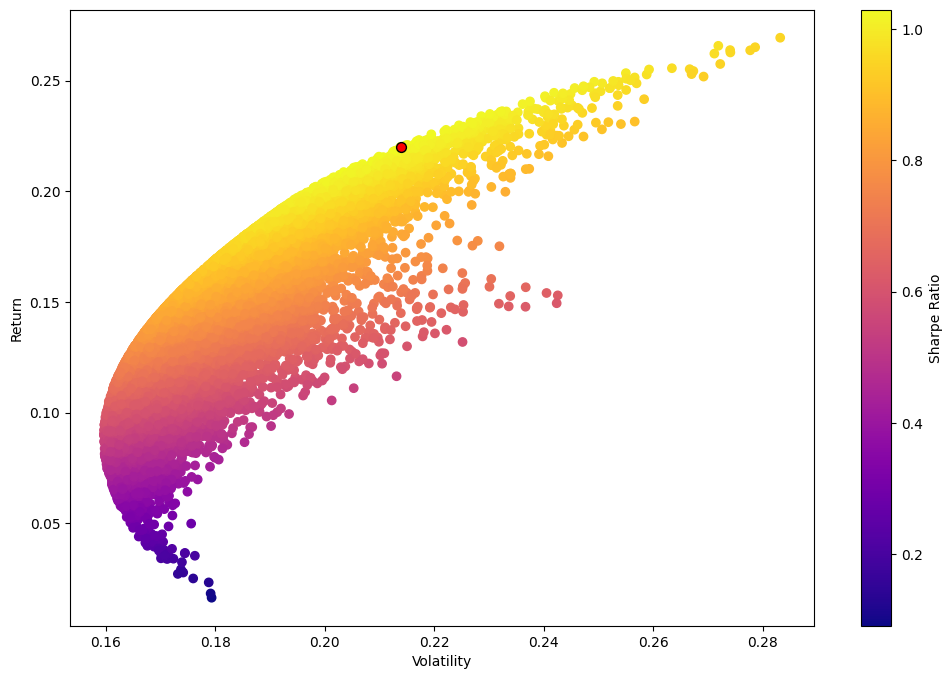

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [30]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean()*weights)*252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [31]:
from scipy.optimize import minimize

In [32]:
# help(minimize) # for documentatoin

In [33]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]*-1

In [34]:
def check_sum(weights):
    return np.sum(weights)-1

In [38]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({"type":"eq","fun":check_sum})

In [39]:
# 0-1 bounds for each weight
bounds = ((0,1),(0,1),(0,1),(0,1))

In [40]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [41]:
# Sequential Least SQuares Programming (SLSQP). there are other methods too
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [42]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0307168703353684
       x: [ 2.663e-01  2.042e-01  0.000e+00  5.295e-01]
     nit: 7
     jac: [ 5.643e-05  4.184e-05  3.399e-01 -4.451e-05]
    nfev: 35
    njev: 7

In [43]:
opt_results.x

array([0.26628977, 0.20418982, 0.        , 0.52952041])

In [44]:
get_ret_vol_sr(opt_results.x)

array([0.21885915, 0.21233683, 1.03071687])

In [46]:
# Our returns go from 0 to somewhere along 0.3 based on bullet chart
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [47]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [49]:
frontier_volatility = []
#efficient frontier is a set of optimal portfolios
# that offer the highest expected return for a defined level of risk 
#or the lowest risk for a given level of expected return.

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

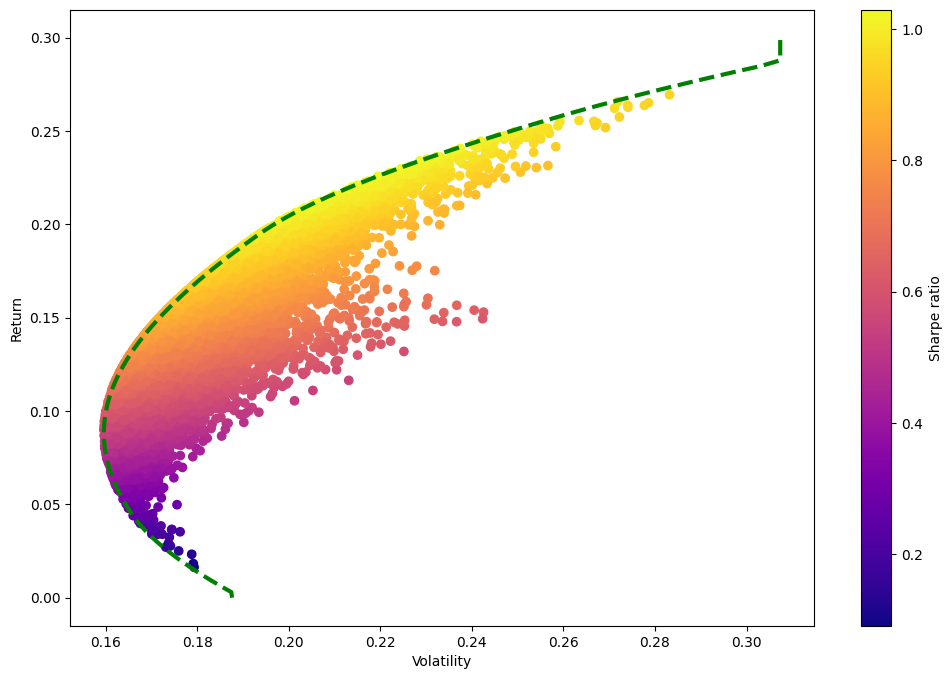

In [55]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility,frontier_y,'g--',lw=3)